Loading: C:\Users\PUPPALA ADITYA\OneDrive\Documents\Desktop\hospital-readmission-prediction-main\backend\data\hospital_readmissions.csv
Loaded (25000, 17)
Features: (25000, 67) Target dist: {0: np.int64(13246), 1: np.int64(11754)}
✅ Resampled shape: (5205, 67) (5205,)

--- Fold 1 ---
RF best: {'max_depth': 20, 'n_estimators': 100}
XGB best: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Fold 1 -> Acc: 0.7896, F1: 0.8238, ROC-AUC: 0.8729 (thresh=0.39)

--- Fold 2 ---
RF best: {'max_depth': 20, 'n_estimators': 100}
XGB best: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Fold 2 -> Acc: 0.8050, F1: 0.8227, ROC-AUC: 0.8856 (thresh=0.52)

--- Fold 3 ---
RF best: {'max_depth': 20, 'n_estimators': 100}
XGB best: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Fold 3 -> Acc: 0.7723, F1: 0.8062, ROC-AUC: 0.8609 (thresh=0.41)

--- Fold 4 ---
RF best: {'max_depth': 20, 'n_estimators': 100}
XGB best: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


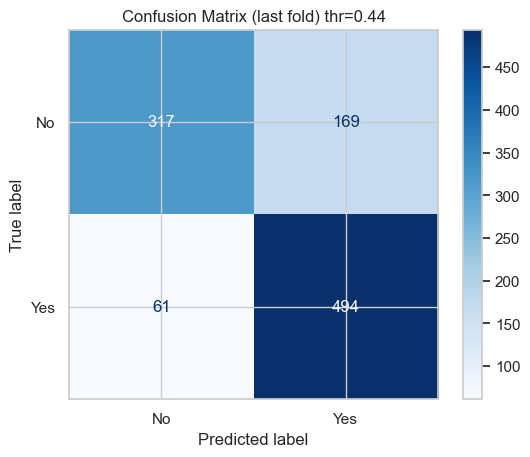

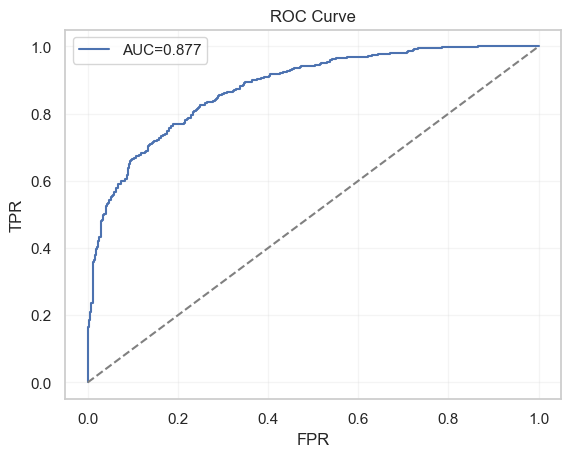

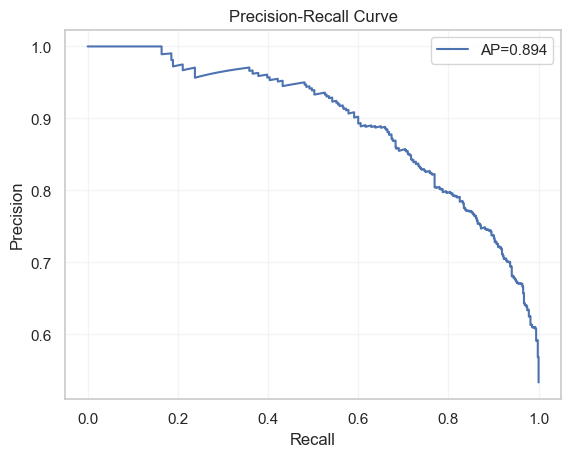

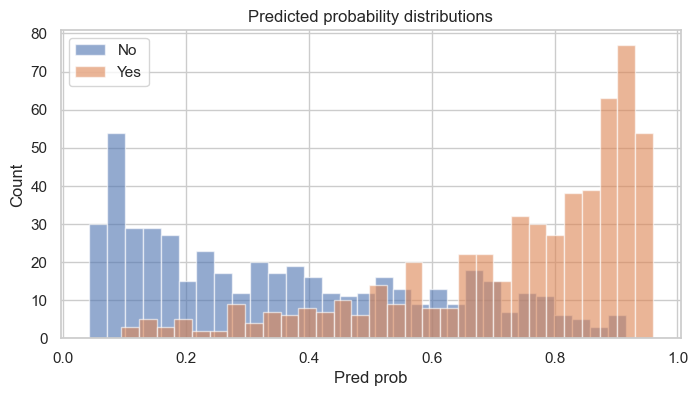


Classification report:

              precision    recall  f1-score   support

           0     0.8386    0.6523    0.7338       486
           1     0.7451    0.8901    0.8112       555

    accuracy                         0.7791      1041
   macro avg     0.7919    0.7712    0.7725      1041
weighted avg     0.7888    0.7791    0.7750      1041

Computing SHAP summary (may take a moment)...


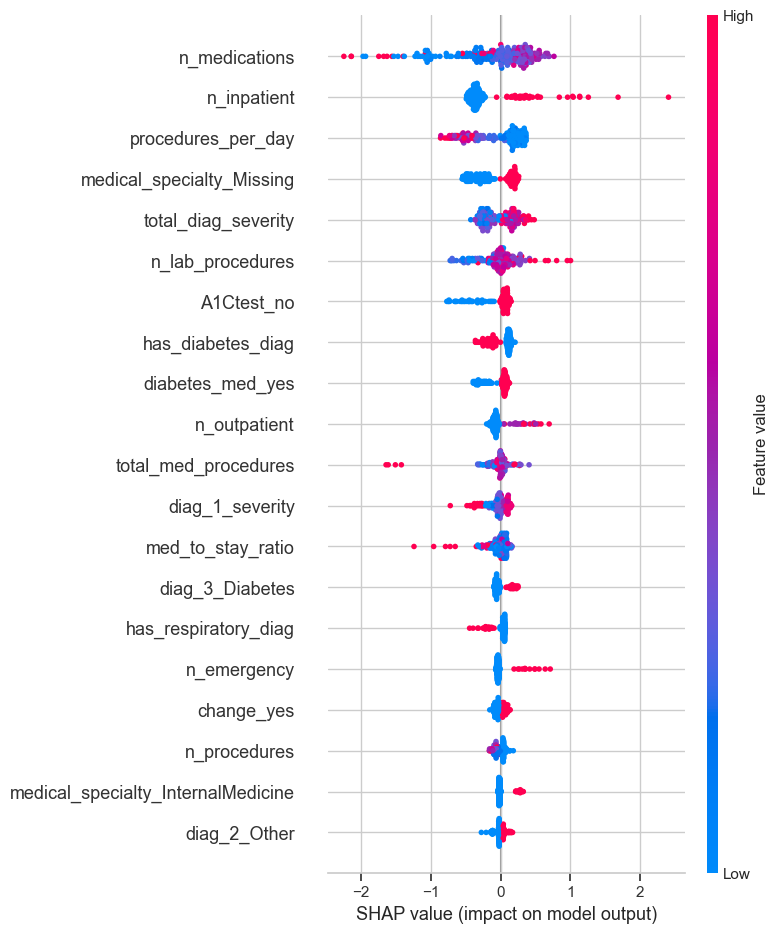

Finished.


In [10]:
# train_safe.py
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import traceback
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, average_precision_score

# ----------------------------
# Config
# ----------------------------
CSV_PATH = r"C:\Users\PUPPALA ADITYA\OneDrive\Documents\Desktop\hospital-readmission-prediction-main\backend\data\hospital_readmissions.csv"
OUTPUT_DIR = "model_artifacts"
RANDOM_STATE = 42
# Use 1 to be conservative and avoid worker crashes. If you have a beefy machine and enough RAM,
# set to -1 to use all cores (but you may get TerminatedWorkerError).
GRIDSEARCH_N_JOBS = 1

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------------------
# Load
# ----------------------------
print("Loading:", CSV_PATH)
df = pd.read_csv(CSV_PATH)
print("Loaded", df.shape)

# ----------------------------
# Feature engineering
# ----------------------------
df['num_diagnoses'] = df[['diag_1','diag_2','diag_3']].count(axis=1)
df['total_med_procedures'] = df['n_lab_procedures'] + df['n_procedures']
df['med_to_stay_ratio'] = (df['n_medications'] / df['time_in_hospital']).replace([np.inf, -np.inf], 0).fillna(0)
df['had_procedures'] = (df['n_procedures'] > 0).astype(int)
df['procedures_per_day'] = (df['n_procedures'] / (df['time_in_hospital'] + 1)).replace([np.inf, -np.inf], 0).fillna(0)
df['procedures_vs_medications'] = (df['n_procedures'] / (df['n_medications'] + 1)).replace([np.inf, -np.inf], 0).fillna(0)
df['procedures_interaction'] = df['n_procedures'] * df['time_in_hospital']

def simplify_age_group(age_range):
    if pd.isna(age_range): return 'Other'
    if age_range in ['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)']:
        return 'Young'
    elif age_range in ['[50-60)','[60-70)','[70-80)']:
        return 'Middle-aged'
    else:
        return 'Senior'

df['age_group_simplified'] = df['age'].apply(simplify_age_group) if 'age' in df.columns else 'Other'

def simplify_diag(diag):
    if pd.isna(diag): return 'Other'
    diag = str(diag).lower()
    if 'diabetes' in diag: return 'Diabetes'
    if 'circulatory' in diag: return 'Circulatory'
    if 'respiratory' in diag: return 'Respiratory'
    if 'digestive' in diag: return 'Digestive'
    if 'injury' in diag: return 'Injury'
    if 'musculoskeletal' in diag: return 'Musculoskeletal'
    return 'Other'

for c in ['diag_1','diag_2','diag_3']:
    df[c] = df[c].apply(simplify_diag) if c in df.columns else 'Missing'

diag_groups = ['Respiratory','Circulatory','Diabetes','Digestive','Other','Injury','Musculoskeletal','Missing']
for dg in diag_groups:
    df[f'has_{dg.lower()}_diag'] = ((df['diag_1']==dg) | (df['diag_2']==dg) | (df['diag_3']==dg)).astype(int)
    df[f'{dg.lower()}_procedures_interaction'] = df[f'has_{dg.lower()}_diag'] * df['n_procedures']

diag_severity = {'Respiratory':7,'Circulatory':6,'Diabetes':5,'Digestive':4,'Other':3,'Injury':2,'Musculoskeletal':1,'Missing':0}
for c in ['diag_1','diag_2','diag_3']:
    df[f'{c}_severity'] = df[c].map(diag_severity)
df['max_diag_severity'] = df[[f'{c}_severity' for c in ['diag_1','diag_2','diag_3']]].max(axis=1)
df['total_diag_severity'] = df[[f'{c}_severity' for c in ['diag_1','diag_2','diag_3']]].sum(axis=1)

# ----------------------------
# Preprocess
# ----------------------------
if 'age' in df.columns:
    df = df.drop(['age'], axis=1)

if 'medical_specialty' in df.columns:
    top_n_specialties = df['medical_specialty'].value_counts().nlargest(10).index.tolist()
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if x in top_n_specialties else 'Other')
else:
    df['medical_specialty'] = 'Other'

categorical_cols = [c for c in ['medical_specialty','diag_1','diag_2','diag_3','glucose_test','A1Ctest','change','diabetes_med','age_group_simplified'] if c in df.columns]
numerical_cols = [c for c in df.columns if c not in categorical_cols + ['readmitted']]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

if 'readmitted' not in df.columns:
    raise RuntimeError("Target column 'readmitted' not found in CSV. Please check the file.")
df['readmitted'] = df['readmitted'].map({'no':0,'yes':1}).astype(int)

# sanitize column names
df.columns = [str(c).replace('[','_').replace(']','_').replace('<','_').replace(',','_').replace('(','_').replace(')','_').replace(' ','_') for c in df.columns]

X = df.drop('readmitted', axis=1)
y = df['readmitted']

print("Features:", X.shape, "Target dist:", dict(y.value_counts()))

# ----------------------------
# Resample BEFORE CV (SMOTEENN)
# ----------------------------
smote_enn = SMOTEENN(random_state=RANDOM_STATE)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print("✅ Resampled shape:", X_resampled.shape, y_resampled.shape)

if not isinstance(X_resampled, pd.DataFrame):
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

numerical_cols_after = [c for c in X_resampled.columns if c in numerical_cols]

# ----------------------------
# CV + Training (safe)
# ----------------------------
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_cols_after)], remainder='passthrough')

f1_scores, roc_scores, acc_scores = [], [], []
last_fold = {}

for fold, (train_idx, test_idx) in enumerate(rkf.split(X_resampled, y_resampled), 1):
    print(f"\n--- Fold {fold} ---")
    X_train_raw = X_resampled.iloc[train_idx].reset_index(drop=True)
    X_test_raw  = X_resampled.iloc[test_idx].reset_index(drop=True)
    y_train = y_resampled.iloc[train_idx].reset_index(drop=True)
    y_test  = y_resampled.iloc[test_idx].reset_index(drop=True)

    X_train = preprocessor.fit_transform(X_train_raw)
    X_test  = preprocessor.transform(X_test_raw)

    # Base logistic (fast)
    log_clf = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, max_iter=2000)
    log_clf.fit(X_train, y_train)

    # RandomForest grid (safe)
    rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
    grid_rf = GridSearchCV(rf_clf, {'n_estimators':[100], 'max_depth':[10,20]}, cv=3, scoring='f1', n_jobs=GRIDSEARCH_N_JOBS, error_score='raise')
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_
    print("RF best:", grid_rf.best_params_)

    # XGBoost: use hist tree method and single-threaded inside estimator to be safe
    # We'll try to run GridSearchCV with GRIDSEARCH_N_JOBS; if it fails due to worker termination,
    # we retry single-threaded by setting n_jobs=1 on GridSearchCV and XGBoost.
    xgb_base = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        verbosity=0,
        random_state=RANDOM_STATE,
        tree_method='hist',   # faster + lower memory
        n_jobs=1              # restrict threads inside xgboost
    )
    xgb_param_grid = {'n_estimators':[100], 'learning_rate':[0.1], 'max_depth':[3,5]}
    grid_xgb = GridSearchCV(xgb_base, xgb_param_grid, cv=3, scoring='f1', n_jobs=GRIDSEARCH_N_JOBS, error_score='raise')

    try:
        grid_xgb.fit(X_train, y_train)
    except Exception as e:
        # Worker error — retry single-threaded (safe fallback)
        print("GridSearchCV/XGBoost failed with parallel workers. Retrying single-threaded... Error:")
        traceback.print_exc()
        grid_xgb = GridSearchCV(xgb_base, xgb_param_grid, cv=3, scoring='f1', n_jobs=1, error_score='raise')
        grid_xgb.fit(X_train, y_train)

    best_xgb = grid_xgb.best_estimator_
    print("XGB best:", grid_xgb.best_params_)

    # Stacking
    stack_clf = StackingClassifier(
        estimators=[('lr', log_clf), ('rf', best_rf), ('xgb', best_xgb)],
        final_estimator=LogisticRegression(),
        cv=3,
        n_jobs=1
    )
    stack_clf.fit(X_train, y_train)

    # threshold selection on this fold
    y_probs = stack_clf.predict_proba(X_test)[:,1]
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_thresh, best_f1 = 0.5, 0.0
    for t in thresholds:
        f1 = f1_score(y_test, (y_probs >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_thresh = f1, t

    y_pred = (y_probs >= best_thresh).astype(int)
    fold_acc = accuracy_score(y_test, y_pred)
    fold_roc = roc_auc_score(y_test, y_probs)
    print(f"Fold {fold} -> Acc: {fold_acc:.4f}, F1: {best_f1:.4f}, ROC-AUC: {fold_roc:.4f} (thresh={best_thresh:.2f})")

    f1_scores.append(best_f1)
    roc_scores.append(fold_roc)
    acc_scores.append(fold_acc)

    last_fold = {
        'X_test_raw': X_test_raw,
        'y_test': y_test,
        'y_probs': y_probs,
        'y_pred': y_pred,
        'best_thresh': best_thresh,
        'stack_clf': stack_clf,
        'best_xgb': best_xgb,
        'best_rf': best_rf,
        'preprocessor': preprocessor
    }

# Summary
print("\n✅ Average F1:", np.mean(f1_scores))
print("✅ Average ROC-AUC:", np.mean(roc_scores))
print("✅ Average Accuracy:", np.mean(acc_scores))

# Save artifacts
joblib.dump(last_fold['stack_clf'], os.path.join(OUTPUT_DIR, 'stack_model.joblib'))
joblib.dump(last_fold['preprocessor'], os.path.join(OUTPUT_DIR, 'preprocessor.joblib'))
joblib.dump(last_fold['best_xgb'], os.path.join(OUTPUT_DIR, 'best_xgb.joblib'))
joblib.dump(last_fold['best_rf'], os.path.join(OUTPUT_DIR, 'best_rf.joblib'))
print("Saved artifacts to", OUTPUT_DIR)

# ----------------------------
# Visualize last fold
# ----------------------------
if last_fold:
    y_test = last_fold['y_test']
    y_probs = last_fold['y_probs']
    y_pred = last_fold['y_pred']
    best_thresh = last_fold['best_thresh']

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No','Yes'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix (last fold) thr={best_thresh:.2f}")
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.grid(alpha=0.2)
    plt.show()

    # PR curve
    prec, rec, _ = precision_recall_curve(y_test, y_probs)
    ap = average_precision_score(y_test, y_probs)
    plt.figure()
    plt.plot(rec, prec, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend(); plt.grid(alpha=0.2)
    plt.show()

    # Probability histograms
    plt.figure(figsize=(8,4))
    plt.hist(y_probs[y_test==0], bins=30, alpha=0.6, label="No")
    plt.hist(y_probs[y_test==1], bins=30, alpha=0.6, label="Yes")
    plt.title("Predicted probability distributions")
    plt.xlabel("Pred prob"); plt.ylabel("Count"); plt.legend(); plt.show()

    # Classification report
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred, digits=4))

    # Optional SHAP (fast TreeExplainer on XGBoost)
    try:
        import shap
        print("Computing SHAP summary (may take a moment)...")
        best_xgb = last_fold['best_xgb']
        preproc = last_fold['preprocessor']
        X_test_raw = last_fold['X_test_raw']
        X_test_proc = preproc.transform(X_test_raw)
        # feature names: numeric cols first, then passthrough columns (approx.)
        num_cols = numerical_cols_after
        passthrough_cols = [c for c in X_test_raw.columns if c not in num_cols]
        feature_names = num_cols + passthrough_cols
        expl = shap.TreeExplainer(best_xgb)
        sample_n = min(200, X_test_proc.shape[0])
        shap_vals = expl.shap_values(X_test_proc[:sample_n])
        shap.summary_plot(shap_vals, X_test_proc[:sample_n], feature_names=feature_names, show=True)
    except Exception as e:
        print("SHAP skipped (not installed or failed). Error:", e)

print("Finished.")
